In [3]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Simulate Buying and Selling Stock Using ARMA(p,q)

In [41]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit()
                # print('curr_data')
                # print(curr_data)
                
                #get forecast
                # pred = model.forecast()[0][0]
                pred = model.forecast().values[0]

            except Exception as e:
                print('e')
                print(e)
                pred = thresh - 1

        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(5,2))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

# Read Data

In [5]:
tickerSymbol = 'AAPL'
data = yf.Ticker(tickerSymbol)

In [6]:
prices = data.history(start='2021-01-01', end='2021-04-01').Close
returns = prices.pct_change().dropna()

(array([18628.20833333, 18642.20833333, 18659.20833333, 18673.20833333,
        18687.20833333, 18701.16666667, 18718.16666667]),
 [Text(18628.208333333332, 0, '2021-01-01'),
  Text(18642.208333333332, 0, '2021-01-15'),
  Text(18659.208333333332, 0, '2021-02-01'),
  Text(18673.208333333332, 0, '2021-02-15'),
  Text(18687.208333333332, 0, '2021-03-01'),
  Text(18701.166666666668, 0, '2021-03-15'),
  Text(18718.166666666668, 0, '2021-04-01')])

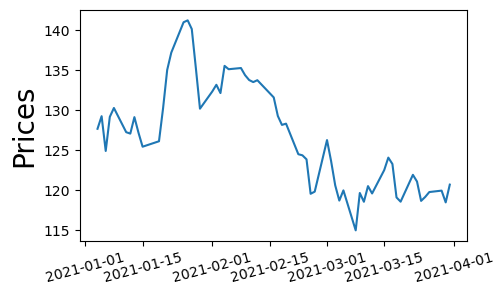

In [7]:
plt.figure(figsize=(5,3))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)
plt.xticks(rotation=15)

(array([18628.20833333, 18642.20833333, 18659.20833333, 18673.20833333,
        18687.20833333, 18701.16666667, 18718.16666667]),
 [Text(18628.208333333332, 0, '2021-01-01'),
  Text(18642.208333333332, 0, '2021-01-15'),
  Text(18659.208333333332, 0, '2021-02-01'),
  Text(18673.208333333332, 0, '2021-02-15'),
  Text(18687.208333333332, 0, '2021-03-01'),
  Text(18701.166666666668, 0, '2021-03-15'),
  Text(18718.166666666668, 0, '2021-04-01')])

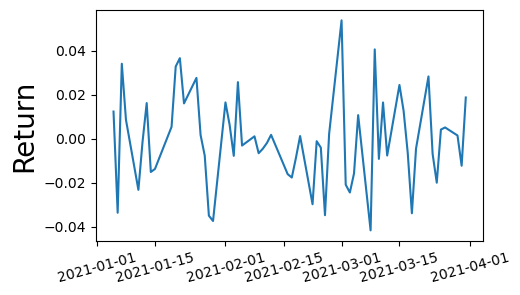

In [8]:
plt.figure(figsize=(5,3))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)
plt.xticks(rotation=15)

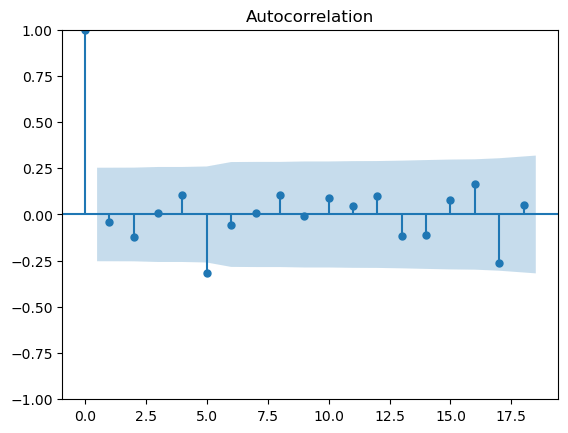

In [7]:
plot_acf(returns)
plt.show()

/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


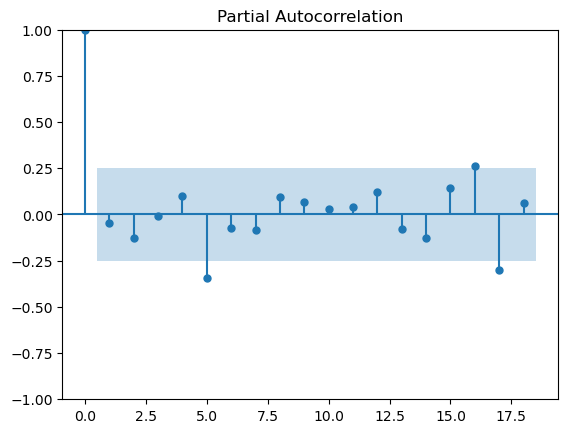

In [8]:
plot_pacf(returns)
plt.show()

# Baseline Model : Random Buying 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 9587.46it/s]


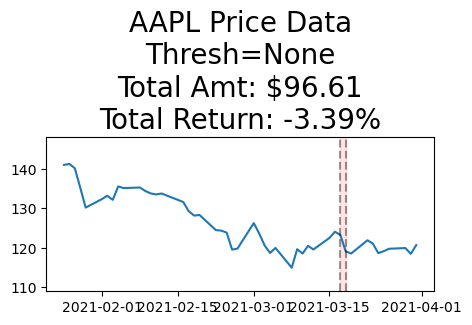

96.60949081401866

In [9]:
run_simulation(returns, prices, 100, 0.05, None, verbose=False)

In [36]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 18065.35it/s]


Text(0.5, 1.0, 'Avg: $95.2\nSD: $6.5')

<Figure size 500x800 with 0 Axes>

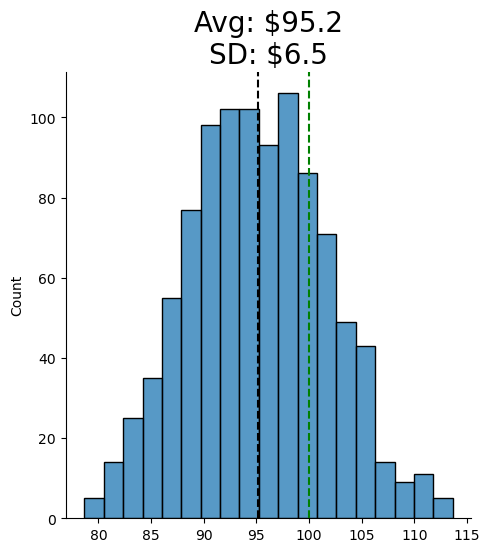

In [43]:
plt.figure(figsize=(5,8))
sns.displot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

# If Last Return was Positive, Buy

100%|████████████████| 46/46 [00:00<00:00, 1175.88it/s]


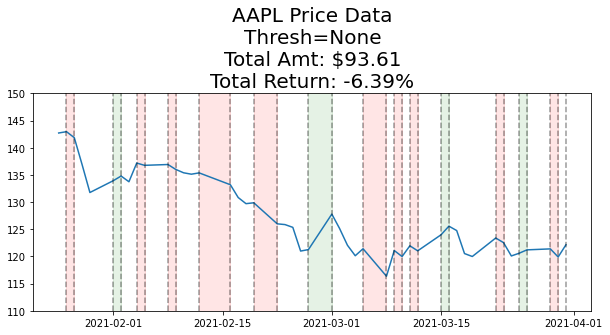

93.6131755279114

In [12]:
run_simulation(returns, prices, 100, 'last', None, verbose=False)

# Try AR(1) Model

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 47.29it/s]


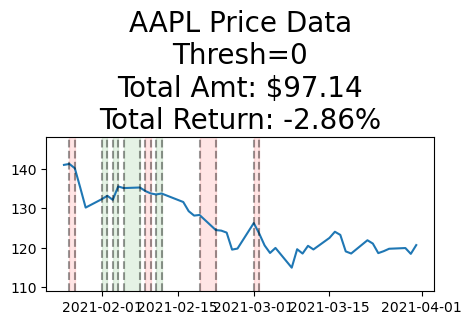

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 47.68it/s]


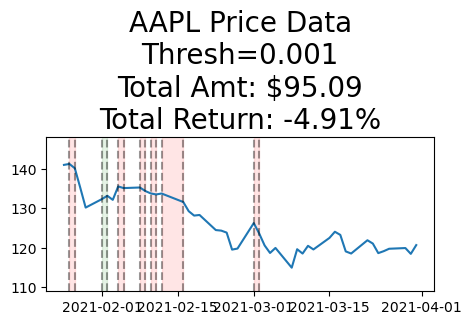

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 42.59it/s]


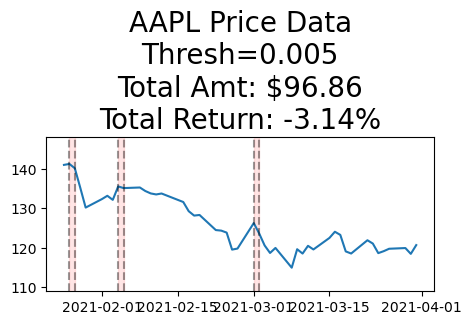

In [42]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1,0,0), thresh, verbose=False)

# Try AR(5) Model

  4%|████▊                                                                                                           | 2/46 [00:00<00:05,  7.54it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
  7%|███████▎                                                                                                        | 3/46 [00:00<00:05,  7.48it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:04<00:00, 10.34it/s]


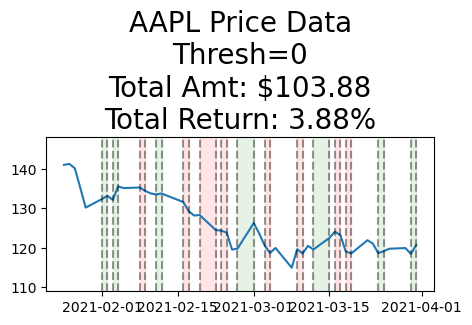

  4%|████▊                                                                                                           | 2/46 [00:00<00:05,  7.64it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
  7%|███████▎                                                                                                        | 3/46 [00:00<00:05,  7.64it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:04<00:00, 10.28it/s]


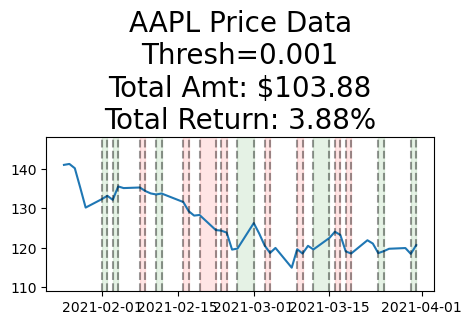

  4%|████▊                                                                                                           | 2/46 [00:00<00:05,  7.73it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
  7%|███████▎                                                                                                        | 3/46 [00:00<00:05,  7.60it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  8.48it/s]


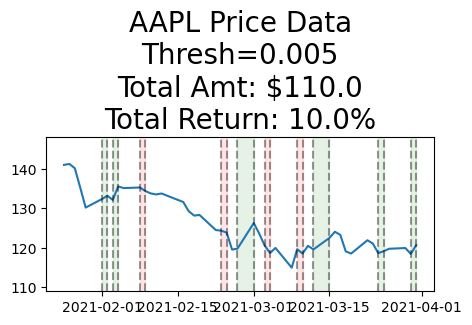

In [43]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,0), thresh, verbose=False)

# Try ARMA(5,5) Model

  0%|                                                                                                                        | 0/46 [00:00<?, ?it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  4%|████▊                                                                                                           | 2/46 [00:00<00:10,  4.21it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Users/sebastian/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sebastian/anac

e
Schur decomposition solver error.
e
Schur decomposition solver error.


 13%|██████████████▌                                                                                                 | 6/46 [00:00<00:04,  8.03it/s]

e
Schur decomposition solver error.
e
Schur decomposition solver error.


/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 15%|█████████████████                                                                                               | 7/46 [00:01<00:06,  5.75it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 20%|█████████████████████▉                                                                                          | 9/46 [00:01<00:05,  6.41it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inver

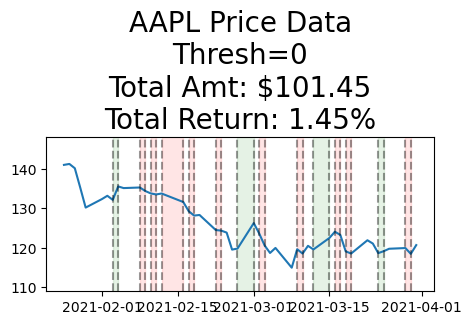

  0%|                                                                                                                        | 0/46 [00:00<?, ?it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  4%|████▊                                                                                                           | 2/46 [00:00<00:10,  4.32it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Users/sebastian/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sebastian/anac

e
Schur decomposition solver error.
e
Schur decomposition solver error.


 13%|██████████████▌                                                                                                 | 6/46 [00:00<00:04,  8.09it/s]

e
Schur decomposition solver error.
e
Schur decomposition solver error.


/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 15%|█████████████████                                                                                               | 7/46 [00:01<00:06,  5.78it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 20%|█████████████████████▉                                                                                          | 9/46 [00:01<00:05,  6.29it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inver

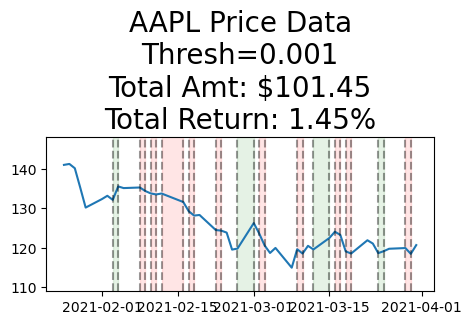

  0%|                                                                                                                        | 0/46 [00:00<?, ?it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  4%|████▊                                                                                                           | 2/46 [00:00<00:10,  4.03it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Users/sebastian/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/sebastian/anac

e
Schur decomposition solver error.
e
Schur decomposition solver error.


 13%|██████████████▌                                                                                                 | 6/46 [00:00<00:05,  7.96it/s]

e
Schur decomposition solver error.
e
Schur decomposition solver error.


/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 15%|█████████████████                                                                                               | 7/46 [00:01<00:07,  5.15it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 20%|█████████████████████▉                                                                                          | 9/46 [00:01<00:06,  5.73it/s]/Users/sebastian/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inver

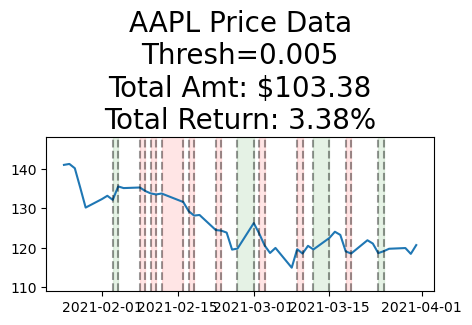

In [44]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,5), thresh, verbose=False)